In [1]:
import torch
import torchvision
from torch import nn

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [3]:
def showBatchImg(images,labels,maxNum=5):
    fig, axes = plt.subplots(1, maxNum)
    for i in range(min(maxNum,images.shape[0])):
        axes[i].imshow(images[i].squeeze())
        axes[i].set_title(labels[i].item())
        axes[i].axis('off')

# images, labels = next(iter(trainloader))
# showBatchImg(images, labels, 10)
# print(images.shape)

## Load DataSet

In [4]:
## Load DataSet

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((28,28)),
        torchvision.transforms.ToTensor()
     ])

batch_size = 1000

trainset = torchvision.datasets.MNIST(root='L:/Datasets', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)

torch.Size([1000, 1, 28, 28])


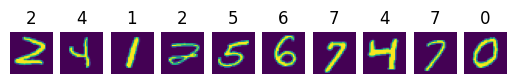

In [5]:
images, labels = next(iter(trainloader))
showBatchImg(images, labels, 10)
print(images.shape)

## VAE

参考：https://github.com/pytorch/examples/blob/main/vae/main.py

```
           FLATTEN_IMG
                   |           |
                   |  |     |  |  
                   |  |  |  |  |
                   |  |     |  |  
                   |           |
                    mu,logvar（Reparameterization：Encoder输出hidden var服从分布的参数）
```

即：hidden layer中某一层的参数是由随机分布 N(mu,sigma) 生成的

In [6]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2_mu = nn.Linear(400, 20)
        self.fc2_logvar = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.nn.functional.relu(self.fc1(x))
        return self.fc2_mu(h1), self.fc2_logvar(h1)

    def decode(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std
        h3 = torch.nn.functional.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
        
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        return self.decode(mu, logvar), mu, logvar
    
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def VAE_loss(recon_x, x, mu, logvar):
    BCE = torch.nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) 
    return BCE + KLD

In [7]:
def train(epoch):
    model.train()
    for e in range(epoch):
        train_loss = 0
        for batch_idx, (x, _) in enumerate(trainloader):
            x = x.to(device)
            optimizer.zero_grad()
            recon_x, mu, logvar = model(x)
            loss = VAE_loss(recon_x, x, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print("epoch:{},loss:{}".format(e,train_loss))

In [8]:
train(30)

epoch:0,loss:15418413.890625
epoch:1,loss:10751970.71875
epoch:2,loss:9243818.546875
epoch:3,loss:8489292.859375
epoch:4,loss:7982173.109375
epoch:5,loss:7648573.46875
epoch:6,loss:7414653.8671875
epoch:7,loss:7245076.3125
epoch:8,loss:7119661.8828125
epoch:9,loss:7018254.515625
epoch:10,loss:6938484.671875
epoch:11,loss:6868027.0078125
epoch:12,loss:6812807.3828125
epoch:13,loss:6764175.625
epoch:14,loss:6720019.4921875
epoch:15,loss:6684691.0078125
epoch:16,loss:6652812.4375
epoch:17,loss:6620410.7890625
epoch:18,loss:6597614.75
epoch:19,loss:6572810.078125
epoch:20,loss:6549932.5625
epoch:21,loss:6528995.59375
epoch:22,loss:6510442.1796875
epoch:23,loss:6496909.9765625
epoch:24,loss:6483315.8984375
epoch:25,loss:6468278.25
epoch:26,loss:6452479.265625
epoch:27,loss:6436155.4296875
epoch:28,loss:6425223.1015625
epoch:29,loss:6417782.4296875


## VAE用途

去噪/降维/预训练decoder

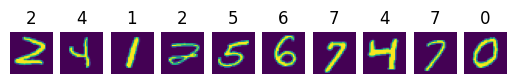

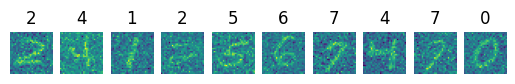

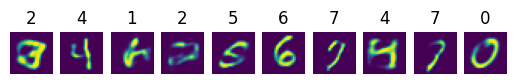

In [9]:
model.eval()
noisy_images = images + torch.randn(images.shape)*0.5
_, mu, logvar = model(noisy_images)
recon_x = model.decode(mu, logvar)

showBatchImg(images, labels, 10)
showBatchImg(noisy_images, labels, 10)
showBatchImg(recon_x.view(-1,28, 28).detach().numpy(), labels, 10)